In [1]:
!echo $PYTHONPATH
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

/usr/lib/python3.10/site-packages


In [2]:
from quilt.builder import NeuronCatalogue, SpikingNetwork

catalogue = NeuronCatalogue.from_yaml("tests/basal_ganglia_neurons.yaml")

Loaded model for neuron 'D1_neuron'

Loaded model for neuron 'D2_neuron'

Loaded model for neuron 'FSN_neuron'

Loaded model for neuron 'GPeTA_neuron'

Loaded model for neuron 'GPeTI_neuron'

Loaded model for neuron 'STN_neuron'

Loaded model for neuron 'SNR_neuron'

In [3]:
sn = SpikingNetwork.from_yaml("tests/basal_ganglia_network.yaml", catalogue)
sn.rescale_populations(1.0)
sn.rescale_connectivity(1.0)
sn.build()

adding population D1

adding population D2

adding population FSN

adding population GPeTI

adding population GPeTA

adding population STN

adding population SNR

Output()

In [4]:
# from quilt.view import plot_graph
# fig, ax = plt.subplots()
# plot_graph(sn)

## Input/Output

In [5]:
pop_state_monitorized = "GPeTI"
for population in sn.populations.values():
    population.monitorize_spikes()
sn.populations[pop_state_monitorized].monitorize_states()

In [6]:
poisson_inputs = dict(STN   = (500, 0.25 ),
                      GPeTA = (170, 0.15),
                      GPeTI = (1530, 0.25 ),
                      FSN   = (944.4, 0.5),
                      SNR   = (6000, 0.55)
                    )

for pop in poisson_inputs:
    sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])

sn.populations["D1"].add_poisson_spike_injector(1120, 0.45)
sn.populations["D2"].add_poisson_spike_injector(972.927, 0.45) 

In [7]:
# sn.run(dt=0.3, time=200)
sn.run(dt=0.1, time=2800)

Running network consisting of 14622 neurons for 28000 timesteps

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Simulation took 105 s	(3.77858 ms/step)
	Gathering time avg: 83.722 us/step
	Inject time avg: 140.614 us/step


In [8]:
spikes = dict()
for pop in sn.populations.keys():
    spikes[pop] = sn.populations[pop].get_data()['spikes']
    # sn.populations[pop].print_info()

states = sn.populations[pop_state_monitorized].get_data()['states']

Mean firing rate D1:	2.1 Hz
Mean firing rate D2:	2.2 Hz
Mean firing rate FSN:	24.1 Hz
Mean firing rate GPeTI:	95.6 Hz
Mean firing rate GPeTA:	14.7 Hz
Mean firing rate STN:	18.5 Hz
Mean firing rate SNR:	16.7 Hz


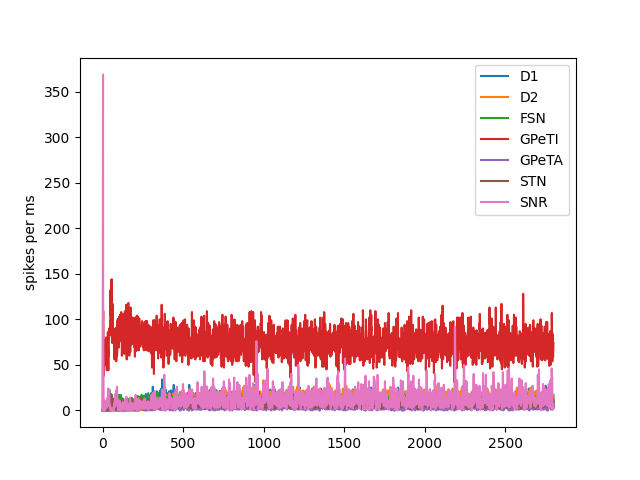

In [10]:
fig, ax = plt.subplots()
timesteps_per_bin = 10
binned_signals = dict()

for pop in spikes.keys():
    binned_signals[pop] = np.sum( 
                            spikes[pop][:-1].reshape(-1, timesteps_per_bin),
                            axis=1).squeeze()
    
    mfr = np.mean(binned_signals[pop][200:]) * 1e3 / sn.populations[pop].n_neurons
    print(f"Mean firing rate {pop}:\t{mfr:.1f} Hz")
    plt.plot(binned_signals[pop], label=pop)
             
# plt.ylim(0,600)
plt.legend()
plt.ylabel("spikes per ms");


D1 17.400000000000002
D2 1.0
FSN 136.6
GPeTI 121.2
GPeTA 17.8
STN 17.5
SNR 17.3


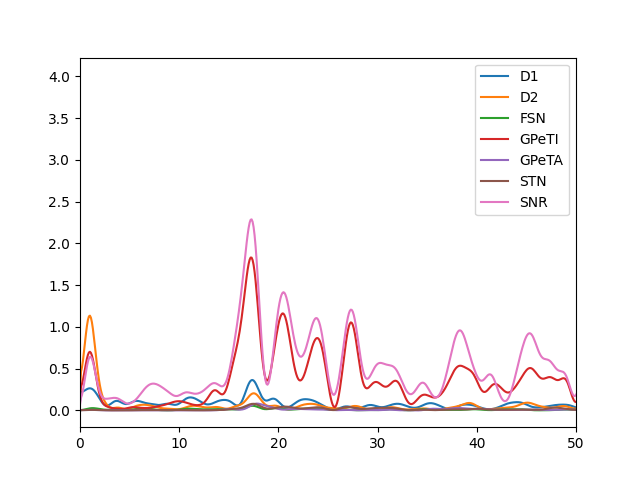

In [11]:
from numpy.fft import fft, fftfreq
from scipy.signal import welch
from sklearn.preprocessing import MinMaxScaler
from neurodsp.filt import filter_signal

fig, ax = plt.subplots()
scaler = MinMaxScaler()

burn_in = 200

for pop in sn.populations.keys():
    signal = binned_signals[pop][burn_in:]

    f, PSD = welch(signal, 
                   1000, 
                   nperseg=800, 
                   noverlap=50,
                   nfft=10000, 
                   scaling='density', 
                   window='hamming')

    # plt.plot(f, scaler.fit_transform(PSD[:, None]).squeeze(), label=pop)
    plt.plot(f, PSD, label=pop)
    print(pop, f[np.argmax(PSD)])
    # break
plt.xlim([0,50]);
plt.legend();